In [1]:
#!pip install -e markov_epidemic

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from markov_epidemic import *

### Network

Barabasi-Albert are typical preferential attachment graphs and have been largely used to model real-world interactions such as social networks. Its main characteristic is the existence of a few hub nodes with many connections. More quantitatively, they exhibit a power law distribution of degrees.

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


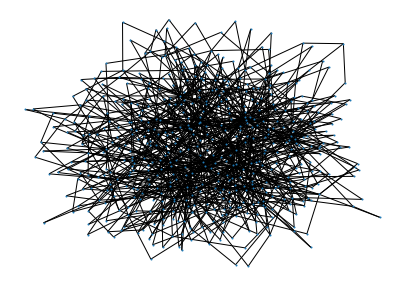

In [2]:
N = 500
G = nx.barabasi_albert_graph(N, 2)

# save layout
# pos = nx.shell_layout(G)
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.axis('off')

plt.show()

## SIS Epidemic

Consider a network $\mathcal{G}$ of $N$ individuals subject to an epidemic disease.
Let $A$ be the adjacency matrix of the underlying graph and $X_i(t)$ the health sandtate of individual $i$ at time $t$.

We assume the following random Markov dynamic:

$$
\begin{cases} 
      \text{susceptible} \rightarrow \text{infected} & \text{at rate $\beta\sum_j A_{ij} \mathbb{1}_{X_j(t) = \text{infected}}$,}  \\
      \text{infected} \rightarrow \text{susceptible} & \text{at rate $\delta$.} \\
   \end{cases}
$$

In other words, the infection rate of an individual is proportional to the number of infected neighbors in the network, and the recovery rate is constant. Also we assume only one individual can change state at a given time $t$ (the events of multiple simultaneous transitions has probability zero anyway).

Note that this is a **Susceptible-Infected-Susceptible (SIS)** model: the Markov property does not allow the process to "remember" its previous infectious states, and therefore individuals are likely to get sick again after having recovered.

### Epidemic parameters

Pretty good recovery rate

In [3]:
infection_rate = 1.0
recovery_rate = 3.0
epidemic = MarkovSIS(infection_rate, recovery_rate, G)

### Adjacency spectrum

The **effective diffusion rate** is $\rho = \frac{\beta}{\delta}$:
* $\rho > 1$: people get infected by a single neighbor faster than they recover,
* $\rho < 1$: people recover faster.

The duration and strength of the epidemic depends on this effective diffusion rate but also on the topology of the underlying social network.

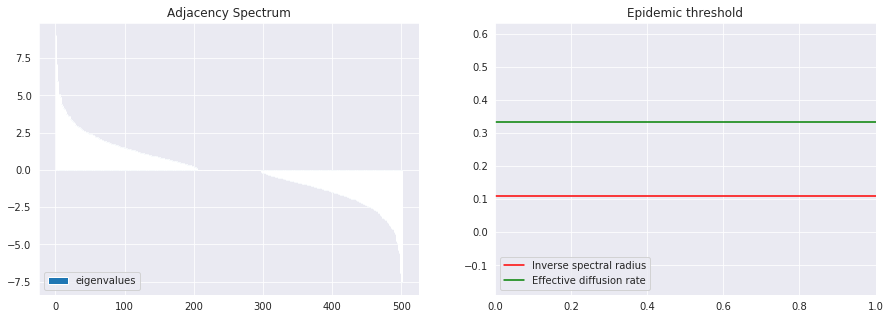

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

    ax = axes[0]
    ax.bar(range(1, N+1), epidemic.spectrum, label='eigenvalues')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')
    
    ax = axes[1]
    isr = 1/epidemic.spectral_radius
    edr = epidemic.effective_diffusion_rate
    ax.axhline(y=isr, color='r', label='Inverse spectral radius')
    ax.axhline(y=edr, color='g', label='Effective diffusion rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(np.min((edr, isr))-0.3, np.max((edr, isr))+0.3)
    ax.set_title('Epidemic threshold')
    ax.legend(loc='lower left')

    plt.show()

### Epidemic simulation: target a random node

In [5]:
T = 10.0
epidemic.simulate(T)

transition_times_random = epidemic.transition_times
fraction_infected_random = epidemic.number_of_infected/epidemic.N

/home/sauxpa/github/markov_epidemic/markov_epidemic/markov_epidemic/markov_epidemic.py:227: RuntimeWarning: divide by zero encountered in true_divide
  holding_times = np.random.exponential(scale=1/rates)


### Epidemic simulation: target a hub

In [6]:
T = 10.0
x0 = np.zeros(N)

hub = list(G.node)[np.argmax(np.array(G.degree)[:, 1])]
x0[hub] = 1

epidemic.simulate(T, x0)

transition_times_hub = epidemic.transition_times
fraction_infected_hub = epidemic.number_of_infected/epidemic.N

### Comparison

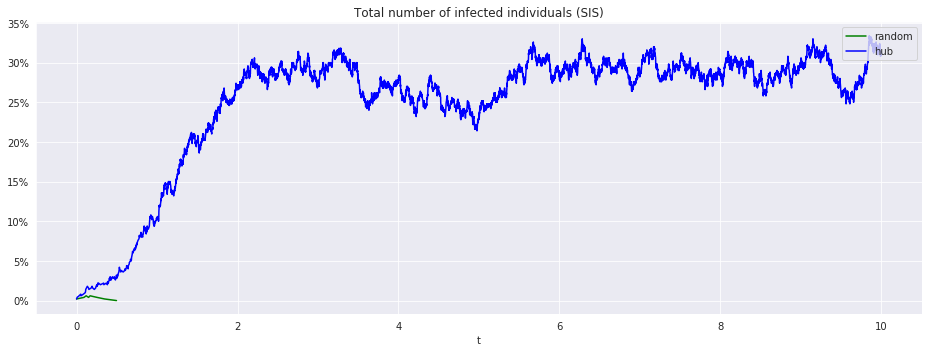

In [7]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(13, 5), nrows=1, ncols=1)

    ax.plot(transition_times_random, fraction_infected_random, label='random', color='g')
    ax.plot(transition_times_hub, fraction_infected_hub, label='hub', color='b')

    ax.set_title('Total number of infected individuals (SIS)')
    ax.set_xlabel('t')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

## SIR Epidemic

Consider a network $\mathcal{G}$ of $N$ individuals subject to an epidemic disease.
Let $A$ be the adjacency matrix of the underlying graph and $X_i(t)$ the health sandtate of individual $i$ at time $t$.

We assume the following random Markov dynamic:

$$
\begin{cases} 
      \text{healthy} \rightarrow \text{infected} & \text{at rate $\beta\sum_j A_{ij} \mathbb{1}_{X_j(t) = \text{infected}}$,}  \\
      \text{infected} \rightarrow \text{recovered} & \text{at rate $\delta$.} \\
   \end{cases}
$$

In other words, the infection rate of an individual is proportional to the number of infected neighbors in the network, and the recovery rate is constant, but once an individual has recovered it can never be infected again. Also we assume only one individual can change state at a given time $t$ (the events of multiple simultaneous transitions have probability zero anyway).

Note that this is a **Susceptible-Infected-Recovered (SIR)** model : once the *recovered* state is reached, the individual remains in this state and can never be infected again.

In [8]:
infection_rate = 1.0
recovery_rate = 3.0
epidemic = MarkovSIR(infection_rate, recovery_rate, G)

### Epidemic simulation: target a random node

In [18]:
T = 10.0
epidemic.simulate(T)

transition_times_random = epidemic.transition_times
fraction_infected_random = epidemic.number_of_infected/epidemic.N

### Epidemic simulation: target a hub

In [19]:
T = 10.0
x0 = np.zeros(N)

hub = list(G.node)[np.argmax(np.array(G.degree)[:, 1])]
x0[hub] = 1

epidemic.simulate(T, x0)

transition_times_hub = epidemic.transition_times
fraction_infected_hub = epidemic.number_of_infected/epidemic.N

### Comparison

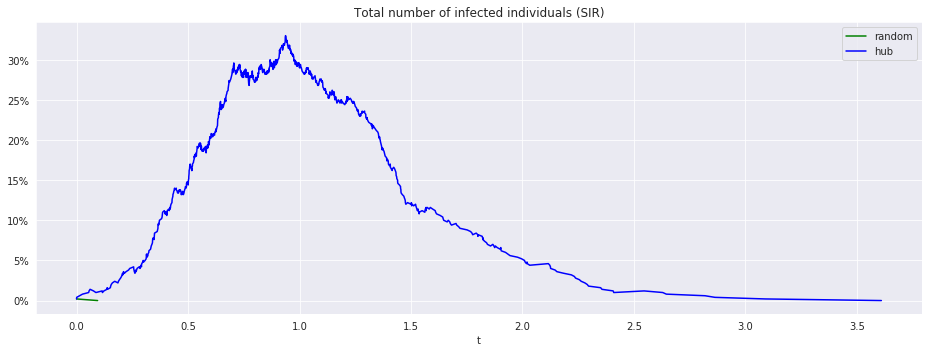

In [20]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(13, 5), nrows=1, ncols=1)

    ax.plot(transition_times_random, fraction_infected_random, label='random', color='g')
    ax.plot(transition_times_hub, fraction_infected_hub, label='hub', color='b')

    ax.set_title('Total number of infected individuals (SIR)')
    ax.set_xlabel('t')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()